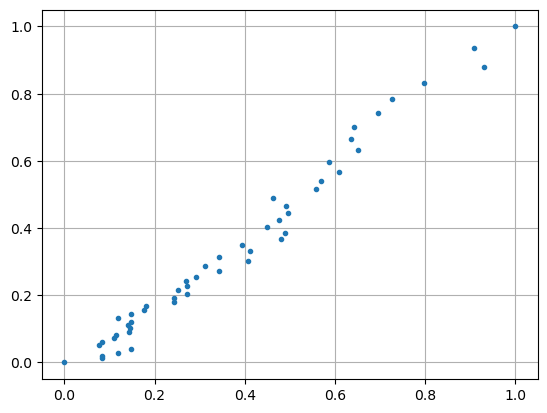

In [26]:
from self_pack import plot_points
from matplotlib import pyplot as plt
path = r'C:\Users\wtana\Desktop\LiDAR_cm\lidar_txt_files\honma_human_leg.txt'
#plotの範囲を全部にするならxmin and xmax に-1
#normalizeするなら1
#しないなら0
x,y,no = plot_points.normalize_points(path,xmin=-40,xmax=0,ymin=0,ymax=100,normalize=1)
#x,y,no = normalize_points(path,xmin=-1,xmax=-1,ymin=0,ymax=500,normalize=0)
plt.plot(x[6],y[6],linestyle='',marker='.')
plt.grid('TRUE')
#plt.xlim(-120,0)
#plt.savefig('../md_matome/images/tree_right_normalize.png')

In [28]:
s = ''
for i in range(len(x)):
    s = ''
    with open('./normalize_txt/40_95/test_wall/'+str(i)+'.txt','a') as f:
        for x_,y_ in zip(x[i],y[i]):
            s = s + str(x_) + ' ' + str(y_) + ' 40\n'
        f.write(s)

In [29]:
import glob
import random
file_path = './normalize_txt/40_95/test_wall/*'
files = glob.glob(file_path)
for idx,file in enumerate(files):
    f = open(file,'r')
    data = f.read().split('\n')
    f.close()
    f = open(file,'a')
    for _ in range(129 -len(data)):
        num = random.randint(0,len(data)-2)
        f.write(str(data[num])+'\n')
    f.close()

In [6]:
import seaborn as sns
iris_df = sns.load_dataset('iris')
iris_df = iris_df.drop(['species'],axis=1)

In [18]:
iris_df

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [14]:
from sklearn.cluster import KMeans
clusters = 3
algorithm = KMeans(n_clusters=clusters)
y_pred = algorithm.fit_predict(iris_df)
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


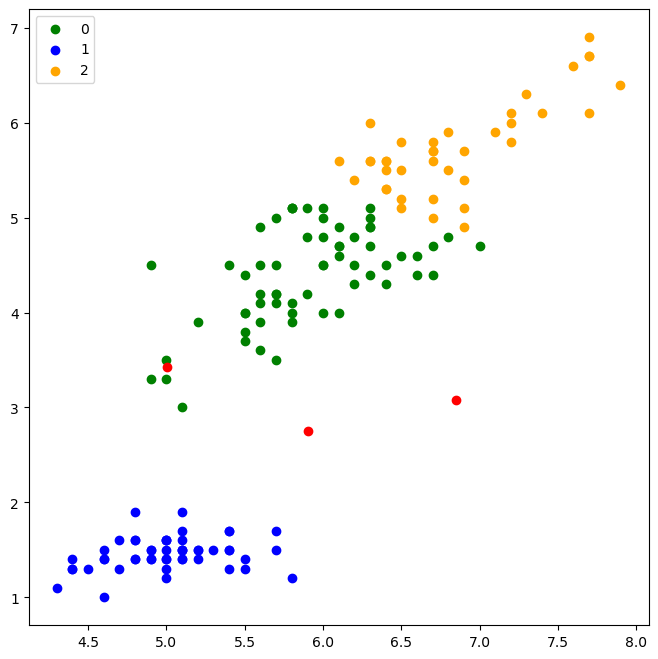

In [19]:
from matplotlib import pyplot as plt

centers = algorithm.cluster_centers_
plt.figure(figsize=(8,8))
plt.plot(centers[:,0],centers[:,1],'o',color='red')

colors = ['green','blue','orange']

for p in set(y_pred):
    idx = y_pred == p
    plt.scatter(iris_df.loc[idx,'sepal_length'],iris_df.loc[idx,'petal_length'],label=str(p),c=colors[p])
    plt.legend()


In [2]:
import torch
from torch_geometric.data import DataLoader as DataLoader

ModuleNotFoundError: No module named 'torch_geometric'